<a href="https://colab.research.google.com/github/enurteagaa/datos_contamaz/blob/main/Copia_de_demo5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Para conocer mejor la temática de las libretas, elabramos un indice donde anotamos las características mas importantes de las libretas (LIBRETA, TITULO, PÁGINAS, PERSONAJESY LUGARES). Para estandarizar la data y que esta pese lo menos posible, lo grabamos en un archivo svc. Sin embargo, al no obtener un codigo funcional, optamos por utilizar una hoja de cálculo.

In [ ]:
from google.colab import files

uploaded = files.upload()  # Esto abrirá una ventana para subir archivos. En este caso el la Hoja de calculo


Saving g4_datos_Contamaz.xlsx to g4_datos_Contamaz.xlsx


FRECUENCIA= numero de veces que aparece el tema en el conjunto de libretas



In [ ]:
from collections import Counter

# Unir todos los temas de las libretas
todos_los_temas = []

for hoja in datos.keys():
    todos_los_temas.extend(datos[hoja]["TEMA"].dropna())  # Eliminar valores nulos

# Contar frecuencia de temas
conteo_temas = Counter(todos_los_temas)

# Convertir a DataFrame
df_temas = pd.DataFrame(conteo_temas.items(), columns=["TEMA", "FRECUENCIA"]).sort_values(by="FRECUENCIA", ascending=False)

# Mostrar los temas más frecuentes
print(df_temas.head(10))


                   TEMA  FRECUENCIA
2              Economía          62
14           Genealogía          41
9              Historia          25
10              Opinión          25
11            Geografía           9
1              Ciencias           6
7            Literatura           6
13          Gastronomía           4
3   Legislación laboral           3
12             Medicina           3


RELACION ENTRE TEMAS PERSONAJES Y LUGARES
Revisa- error/ Iquitos

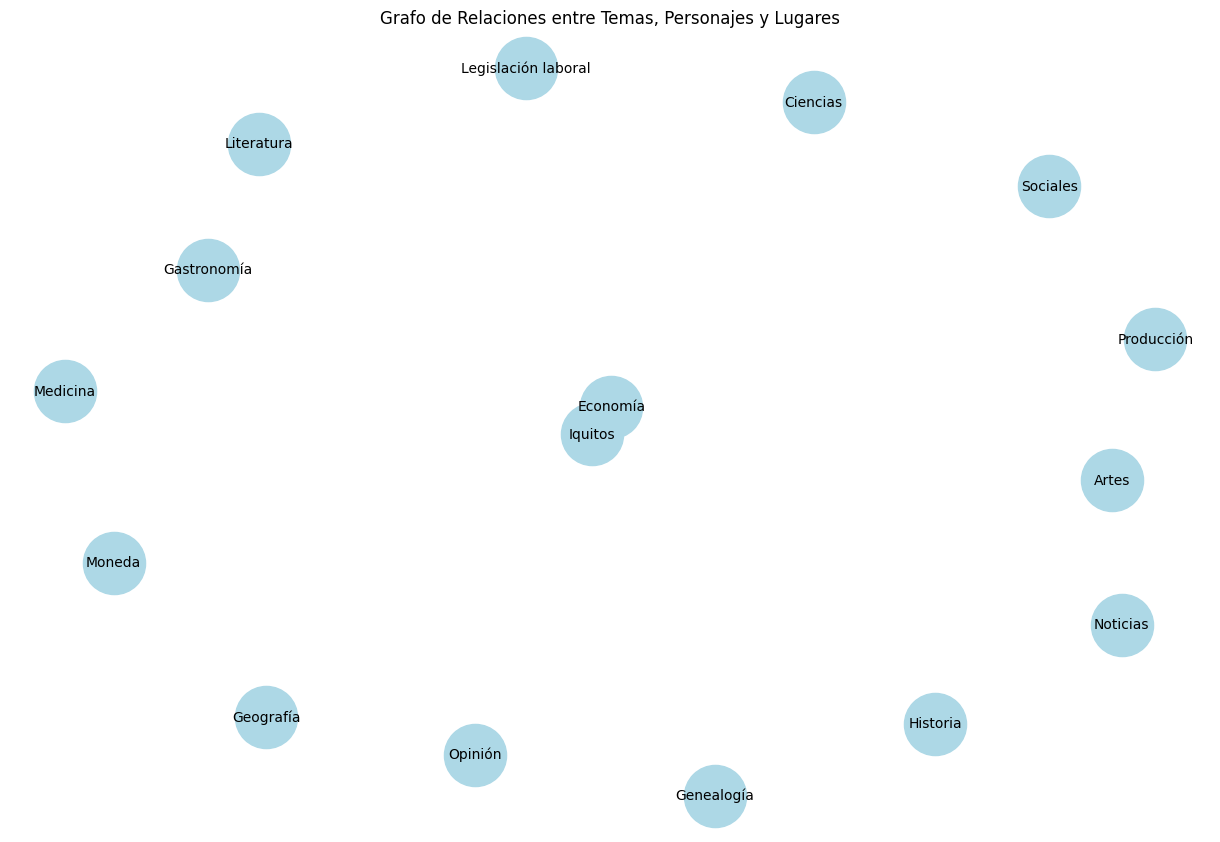

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

# Agregar nodos y relaciones
for hoja in datos.keys():
    df = datos[hoja]
    for _, fila in df.iterrows():
        tema = fila["TEMA"]
        personajes = str(fila["PERSONAJES MENCIONADOS"]).split(",") if pd.notna(fila["PERSONAJES MENCIONADOS"]) else []
        lugares = str(fila["LUGARES MENCIONADOS"]).split(",") if pd.notna(fila["LUGARES MENCIONADOS"]) else []

        G.add_node(tema, tipo="TEMA")
        for personaje in personajes:
            G.add_node(personaje.strip(), tipo="PERSONAJE")
            G.add_edge(tema, personaje.strip())
        for lugar in lugares:
            G.add_node(lugar.strip(), tipo="LUGAR")
            G.add_edge(tema, lugar.strip())

# Dibujar el grafo
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=10)
plt.title("Grafo de Relaciones entre Temas, Personajes y Lugares")
plt.show()


In [ ]:
from itertools import combinations

co_ocurrencias = Counter()

for hoja in datos.keys():
    df = datos[hoja]
    for _, fila in df.iterrows():
        elementos = set()
        if pd.notna(fila["TEMA"]):
            elementos.add(fila["TEMA"])
        if pd.notna(fila["PERSONAJES MENCIONADOS"]):
            elementos.update(map(str.strip, fila["PERSONAJES MENCIONADOS"].split(",")))
        if pd.notna(fila["LUGARES MENCIONADOS"]):
            elementos.update(map(str.strip, fila["LUGARES MENCIONADOS"].split(",")))

        for par in combinations(elementos, 2):
            co_ocurrencias[par] += 1

# Mostrar las co-ocurrencias más frecuentes
print(co_ocurrencias.most_common(10))


[(('Iquitos', 'Economía'), 12)]


<ipython-input-9-55149d5fe55e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_temas["TEMA"][:10], y=df_temas["FRECUENCIA"][:10], palette="viridis")


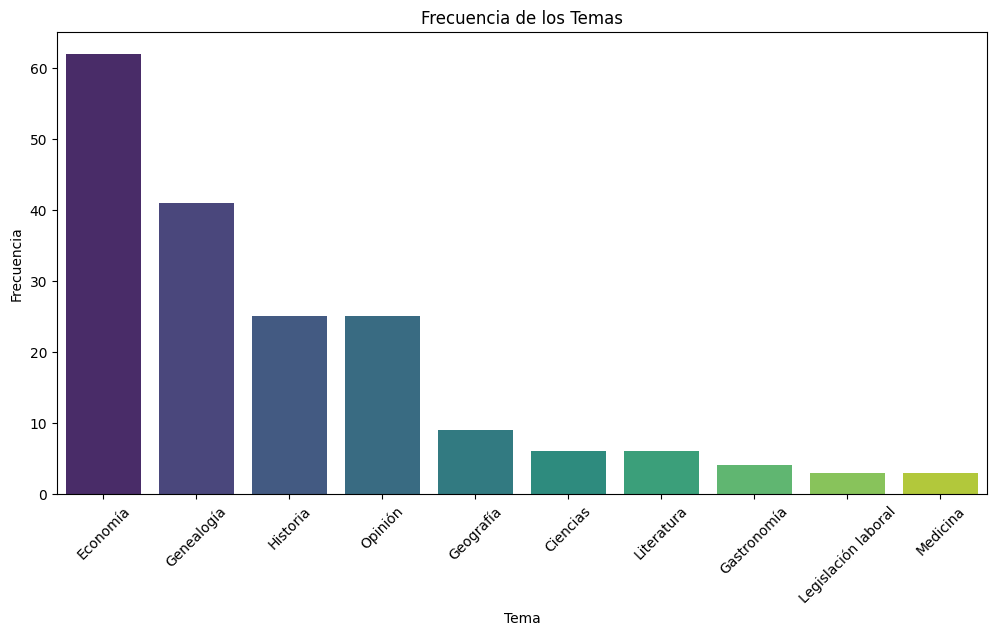

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=df_temas["TEMA"][:10], y=df_temas["FRECUENCIA"][:10], palette="viridis")
plt.xticks(rotation=45)
plt.title("Frecuencia de los Temas")
plt.xlabel("Tema")
plt.ylabel("Frecuencia")
plt.show()


In [ ]:
import folium
from geopy.geocoders import Nominatim

geolocalizador = Nominatim(user_agent="geoapi")
mapa = folium.Map(location=[-9, -75], zoom_start=6)  # Coordenadas aproximadas de Perú

lugares_unicos = set()

for hoja in datos.keys():
    df = datos[hoja]
    for lugar in df["LUGARES MENCIONADOS"].dropna():
        lugares_unicos.update(map(str.strip, lugar.split(",")))

for lugar in lugares_unicos:
    try:
        ubicacion = geolocalizador.geocode(lugar)
        if ubicacion:
            folium.Marker([ubicacion.latitude, ubicacion.longitude], popup=lugar).add_to(mapa)
    except:
        pass  # Si un lugar no se encuentra, lo ignoramos

mapa


In [ ]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output


In [ ]:
# Cargar el archivo Excel
archivo = "g4_datos_Contamaz.xlsx"  # Cambia esto por el nombre exacto de tu archivo
xls = pd.ExcelFile(archivo)

# Cargar todas las hojas en un diccionario de DataFrames
datos = {hoja: xls.parse(hoja) for hoja in xls.sheet_names}


In [ ]:
# Crear un widget de selección para escoger la libreta
libreta_selector = widgets.Dropdown(
    options=xls.sheet_names,  # Lista de libretas en el archivo
    description="Libreta:",
    style={'description_width': 'initial'}
)

# Crear un widget de selección de temas (se llenará dinámicamente)
tema_selector = widgets.Dropdown(
    options=[],  # Se actualizará al escoger una libreta
    description="Tema:",
    style={'description_width': 'initial'}
)

# Botón para mostrar los resultados
boton_mostrar = widgets.Button(description="Mostrar Resultados")

# Output para mostrar los resultados
output = widgets.Output()


In [ ]:
# Función que actualiza los temas cuando se cambia la libreta
def actualizar_temas(*args):
    libreta_elegida = libreta_selector.value
    temas_disponibles = sorted(datos[libreta_elegida]["TEMA"].dropna().unique())  # Obtener temas únicos
    tema_selector.options = temas_disponibles if temas_disponibles else ["(Sin temas disponibles)"]

# Conectar el cambio de libreta con la actualización de temas
libreta_selector.observe(actualizar_temas, names="value")

# Llamamos la función una vez para inicializar los temas
actualizar_temas()


In [ ]:
# Función para mostrar los resultados al presionar el botón
def mostrar_resultados(b):
    with output:
        clear_output(wait=True)  # Limpiar salida previa

        libreta_elegida = libreta_selector.value
        tema_elegido = tema_selector.value

        # Filtrar los datos según la selección
        df_filtrado = datos[libreta_elegida][datos[libreta_elegida]["TEMA"] == tema_elegido]

        # Mostrar el resultado
        display(df_filtrado)

# Asociar la función al botón
boton_mostrar.on_click(mostrar_resultados)


In [ ]:
# Mostrar los widgets en la interfaz
display(libreta_selector, tema_selector, boton_mostrar, output)


Dropdown(description='Libreta:', options=('Hoja1',), style=DescriptionStyle(description_width='initial'), valu…

Dropdown(description='Tema:', options=('Artes', 'Ciencias', 'Economía', 'Gastronomía', 'Genealogía', 'Geografí…

Button(description='Mostrar Resultados', style=ButtonStyle())

Output()